In [1]:
%matplotlib inline
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
from requests import get
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


# Import Data

In [2]:
dfList = []
for r, d, f in os.walk('../data/dunnhumby - The Complete Journey CSV/'):
    for file in f:
        if '.csv' in file:
            print(file)
            dfList.append(pd.read_csv(os.path.join(r, file)))

campaign_desc.csv
campaign_table.csv
causal_data.csv
coupon.csv
coupon_redempt.csv
hh_demographic.csv
product.csv
transaction_data.csv


In [3]:
campaign_desc_df = dfList[0]
campaign_table_df = dfList[1]
causal_data_df = dfList[2]
coupon_df = dfList[3]
coupon_redempt_df = dfList[4]
hh_demographic_df = dfList[5]
product_df = dfList[6]
transaction_data_df = dfList[7]

# Observing Data

In [4]:
campaign_desc_df.head(2)

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708


In [5]:
campaign_table_df.head(2)

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26


In [6]:
causal_data_df.head(2)

,PRODUCT_ID,STORE_ID,WEEK_NO,display,mailer
0,26190,286,70,0,A
1,26190,288,70,0,A


In [7]:
coupon_df.head(2)

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9


In [8]:
coupon_redempt_df.head(2)

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8


In [9]:
hh_demographic_df.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


This seems to be interesting data about households

## Product Data

In [10]:
product_df.head(10)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
5,26426,69,GROCERY,Private,SPICES & EXTRACTS,SPICES & SEASONINGS,2.5 OZ
6,26540,69,GROCERY,Private,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,16 OZ
7,26601,69,DRUG GM,Private,VITAMINS,VITAMIN - MINERALS,300CT(1)
8,26636,69,PASTRY,Private,BREAKFAST SWEETS,SW GDS: SW ROLLS/DAN,
9,26691,16,GROCERY,Private,PNT BTR/JELLY/JAMS,HONEY,12 OZ


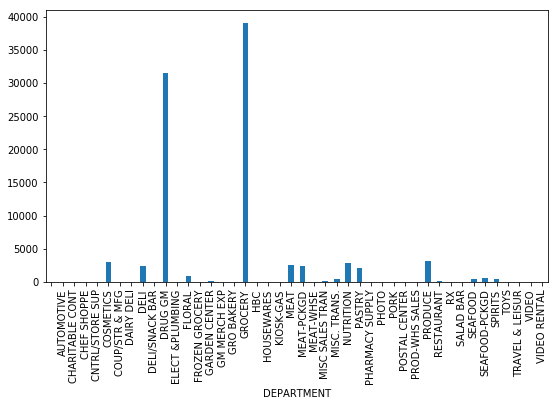

In [11]:
product_df.groupby('DEPARTMENT')['PRODUCT_ID'].count().plot.bar(rot=90,figsize=(9,5))

Let us look at what kind of grocery items we can find

In [12]:
product_df[product_df['DEPARTMENT']=='GROCERY'].groupby('COMMODITY_DESC')['PRODUCT_ID'].count().sort_values(ascending=False)

COMMODITY_DESC
SOFT DRINKS               1704
BAG SNACKS                1523
HISPANIC                  1460
FRZN MEAT/MEAT DINNERS    1268
BAKED BREAD/BUNS/ROLLS    1169
                          ... 
BIRD SEED                   29
FROZEN CHICKEN              27
COUPON/MISC ITEMS           17
FRZN SEAFOOD                11
BOTTLE DEPOSITS             10
Name: PRODUCT_ID, Length: 94, dtype: int64

In [13]:
product_df[(product_df['DEPARTMENT']=='GROCERY') & (product_df['COMMODITY_DESC']=='SOFT DRINKS')]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
146,31126,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ
167,32124,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ
437,41156,69,GROCERY,Private,SOFT DRINKS,SFT DRNK 3 LITER BTL CARB (EXC,3 LTR
463,41794,69,GROCERY,Private,SOFT DRINKS,MIXERS(CLUB SODA/SELTZERS)FLAV,
485,42385,1208,GROCERY,National,SOFT DRINKS,SFT DRNK 2 LITER BTL CARB INCL,2LTR
...,...,...,...,...,...,...,...
92292,18148794,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12/12 OZ
92333,18243940,103,GROCERY,National,SOFT DRINKS,SFT DRNK 2 LITER BTL CARB INCL,2 LTR PET
92334,18244314,1208,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ
92337,18244453,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ PET


Let us look at what kind of 'Drug GM' products we have

In [14]:
product_df[product_df['DEPARTMENT']=='DRUG GM'].groupby('COMMODITY_DESC')['PRODUCT_ID'].count().sort_values(ascending=False)

COMMODITY_DESC
GREETING CARDS/WRAP/PARTY SPLY    2785
CANDY - PACKAGED                  2473
HAIR CARE PRODUCTS                1744
STATIONERY & SCHOOL SUPPLIES      1261
MAGAZINE                          1224
                                  ... 
COUPON/MISC ITEMS                    5
PROPANE                              3
MISCELLANEOUS HBC                    3
FRAGRANCES                           1
FD WRAPS/BAGS/TRSH BG                1
Name: PRODUCT_ID, Length: 91, dtype: int64

## Transaction Data

In [15]:
transaction_data_df.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


# Question 1: How is purchasing rate related to demographics?

If we want to compare shopping amounts amongst households, we are subject to transaction amounts and the time in which they took place. We can compare the shopping rate amongst households by taking the ratio of the cummulative expenditure of a household and the number of days over which they occured.

In [16]:
# turn the days of purchase into a list on a single row
days_purchased_each_house=transaction_data_df.groupby(['household_key','DAY','STORE_ID'])['SALES_VALUE']\
.sum()\
.reset_index()\
.set_index('household_key')\
.groupby('household_key')['DAY'].apply(list)
days_purchased_each_house.head()


household_key
1    [51, 67, 88, 94, 101, 108, 111, 128, 137, 146,...
2    [103, 112, 117, 118, 121, 139, 140, 147, 154, ...
3    [113, 121, 136, 139, 141, 142, 163, 166, 169, ...
4    [104, 140, 154, 181, 190, 199, 216, 231, 244, ...
5    [85, 87, 88, 97, 111, 131, 138, 154, 168, 181,...
Name: DAY, dtype: object

In [17]:
#turn the transaction values into a list on a single row
transaction_val_each_house=transaction_data_df.groupby(['household_key','DAY','STORE_ID'])['SALES_VALUE']\
.sum()\
.reset_index()\
.set_index('household_key')\
.groupby('household_key')['SALES_VALUE'].apply(list)
transaction_val_each_house.head()

household_key
1    [78.66, 41.1, 26.9, 63.43, 53.449999999999996,...
2    [22.7, 4.38, 12.84, 30.849999999999994, 26.94,...
3    [46.81000000000001, 21.450000000000003, 74.43,...
4    [126.23999999999997, 123.77999999999999, 31.75...
5    [4.48, 5.54, 13.68, 60.04000000000001, 58.4899...
Name: SALES_VALUE, dtype: object

In [18]:
#merge the two series on household key
transaction_freq_df = pd.merge(transaction_val_each_house,days_purchased_each_house,\
                               left_on='household_key',right_on='household_key')


In [19]:
transaction_freq_df.head()
    

,SALES_VALUE,DAY
household_key,,
1,"[78.66, 41.1, 26.9, 63.43, 53.449999999999996,...","[51, 67, 88, 94, 101, 108, 111, 128, 137, 146,..."
2,"[22.7, 4.38, 12.84, 30.849999999999994, 26.94,...","[103, 112, 117, 118, 121, 139, 140, 147, 154, ..."
3,"[46.81000000000001, 21.450000000000003, 74.43,...","[113, 121, 136, 139, 141, 142, 163, 166, 169, ..."
4,"[126.23999999999997, 123.77999999999999, 31.75...","[104, 140, 154, 181, 190, 199, 216, 231, 244, ..."
5,"[4.48, 5.54, 13.68, 60.04000000000001, 58.4899...","[85, 87, 88, 97, 111, 131, 138, 154, 168, 181,..."


In [20]:
# Compute the purchase rate 
def compute_transaction_rate(household_df):
    
    #Compute cumulative sum of sales value
    cum_trans = sum(household_df['SALES_VALUE'])
    
    #subtract last day from first day
    x = np.array(household_df['DAY'])
    
    if (x[-1]-x[0])==0: #we filter out single transactions
        purchase_rate = np.nan
    else:
        purchase_rate = cum_trans/(x[-1]-x[0])
    
    return purchase_rate

Text(0, 0.5, 'Frequency')

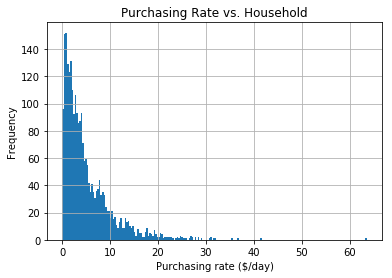

In [21]:
#get purchase rate series
purchase_rate=transaction_freq_df.apply(compute_transaction_rate,axis=1)

#observe distribution of purchase rate
purchase_rate.hist(bins=200)
ax = plt.gca()
ax.set_title('Purchasing Rate vs. Household')
ax.set_xlabel('Purchasing rate ($/day)')
ax.set_ylabel('Frequency')


In [22]:
#Find outliers
purchase_rate.sort_values(ascending=False)

household_key
1023    63.548574
1609    41.643767
2322    36.661891
1453    35.336525
1430    32.051953
          ...    
1647     0.081174
522      0.070870
494           NaN
1830          NaN
1897          NaN
Length: 2500, dtype: float64

In [23]:
#merge with demographic df
purchase_rate.rename('purchase_rate',inplace=True)
hh_demographic_df = hh_demographic_df.join(purchase_rate,on='household_key')

In [24]:
hh_demographic_df.\
groupby('HOUSEHOLD_SIZE_DESC')['purchase_rate'].agg(['mean','std'])

,mean,std
HOUSEHOLD_SIZE_DESC,,
1,7.817810,5.130117
2,8.743405,5.416140
3,9.566740,6.791548
4,10.382001,6.231943
5+,10.325423,7.857083


No relevant correlation with household size

In [25]:
#income description vs. purchase rate
idesc_purchrate = hh_demographic_df\
.groupby(['INCOME_DESC','purchase_rate'])['household_key']\
.count()\
.reset_index().drop(columns='household_key').sort_values(by='purchase_rate',ascending=False)
idesc_purchrate.head(10)

,INCOME_DESC,purchase_rate
71,125-149K,41.643767
186,175-199K,36.661891
70,125-149K,35.336525
451,35-49K,32.051953
33,100-124K,31.569770
800,Under 15K,30.893145
175,150-174K,30.721163
450,35-49K,29.177547
279,250K+,28.505193
278,250K+,28.445489


Let's look at a box-plot instead, since there can be outliers shifting the means

Text(0.5, 0, 'Income Description')

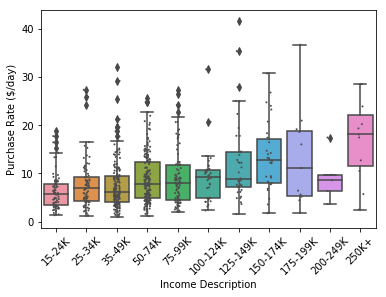

In [26]:
#specify order of boxes in boxplot
order = ['250K+','200-249K','175-199K','150-174K','125-149K','100-124K', '75-99K','50-74K','35-49K','25-34K','15-24K']
order = [o for o in reversed(order)]
#do a box plot
p1=sns.stripplot(x=idesc_purchrate.INCOME_DESC, y=idesc_purchrate.purchase_rate, data=idesc_purchrate,order=order,size=2,color='.3')
p1.set_xticklabels(p1.get_xticklabels(),rotation=45)
p1 = sns.boxplot(x=idesc_purchrate.INCOME_DESC, y=idesc_purchrate.purchase_rate, data=idesc_purchrate,order=order)
p1.set_ylabel('Purchase Rate ($/day)')
p1.set_xlabel('Income Description')

In [27]:
hh_demographic_df.groupby('AGE_DESC')['purchase_rate'].agg(['mean','std']).sort_values(by='mean',ascending=False)

,mean,std
AGE_DESC,,
35-44,9.986070,6.403561
45-54,9.036293,6.286432
25-34,8.548801,5.415285
55-64,7.928738,4.800478
19-24,7.411020,4.467614
65+,6.750850,4.171274


It seems that the strongest correlation exists with income groups. But, we don't know if they are buying the same items. This will be our next question

# What kind of items are bought by these demographic groups? 

In [28]:
# merge transaction df with product df
transaction_product_id_df = transaction_data_df[['household_key','PRODUCT_ID','QUANTITY','SALES_VALUE','DAY']]\
.merge(product_df[['PRODUCT_ID','DEPARTMENT','COMMODITY_DESC','SUB_COMMODITY_DESC','CURR_SIZE_OF_PRODUCT']],on=['PRODUCT_ID'],how='left')

Text(0, 0.5, '# households')

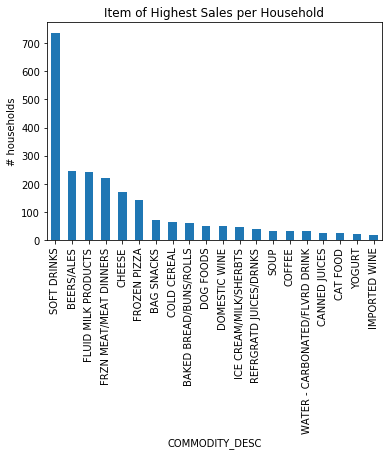

In [29]:
transaction_product_id_df[transaction_product_id_df['DEPARTMENT']=='GROCERY'].\
groupby(['household_key','COMMODITY_DESC'])[['SALES_VALUE','QUANTITY']].\
sum().sort_values(['household_key','SALES_VALUE'],ascending=False).reset_index().\
groupby('household_key').first().reset_index().\
groupby('COMMODITY_DESC')['household_key'].count().\
sort_values(ascending=False).head(20).plot.bar(rot=90)
ax = plt.gca()
ax.set_title('Item of Highest Sales per Household')
ax.set_ylabel('# households')

In [96]:
top_purchased_foods= transaction_product_id_df[transaction_product_id_df['DEPARTMENT']=='GROCERY'].\
groupby(['household_key','COMMODITY_DESC'])[['SALES_VALUE','QUANTITY']].\
sum().sort_values(['household_key','SALES_VALUE'],ascending=False).reset_index().\
groupby('household_key').head(2).reset_index()
top_purchased_foods.head()

,index,household_key,COMMODITY_DESC,SALES_VALUE,QUANTITY
0,0,2500,BEERS/ALES,302.17,23
1,1,2500,CHEESE,142.34,77
2,78,2499,FROZEN PIZZA,164.99,78
3,79,2499,BAG SNACKS,125.42,57
4,153,2498,FLUID MILK PRODUCTS,177.67,70


In [108]:
# make dictionary mapping commodity desc to a numerical value. We'll use the index
unique_com_desc = top_purchased_foods.COMMODITY_DESC.unique()
num_to_desc = dict(enumerate(unique_com_desc))
desc_to_num = {v: k for k, v in num_to_desc.items()}

In [111]:
top_purchased_foods.replace({'COMMODITY_DESC':desc_to_num},inplace=True)

In [112]:
top_purchased_foods.drop(['SALES_VALUE','QUANTITY'],axis=1,inplace=True)

In [113]:
top_purchased_foods = pd.pivot_table(top_purchased_foods,index=['household_key'],\
             columns=top_purchased_foods\
               .groupby(['household_key'])\
             .cumcount().add(1),values=['COMMODITY_DESC'],aggfunc='sum')
top_purchased_foods.columns=  top_purchased_foods.columns.map('{0[0]}{0[1]}'.format) 
top_purchased_foods.head(10)

,COMMODITY_DESC1,COMMODITY_DESC2
household_key,,
1,12.0,5.0
2,5.0,4.0
3,5.0,2.0
4,1.0,2.0
5,6.0,59.0
6,0.0,5.0
7,9.0,25.0
8,9.0,1.0
9,11.0,34.0


In [114]:
top_purchased_foods.dropna(how='any',inplace=True)

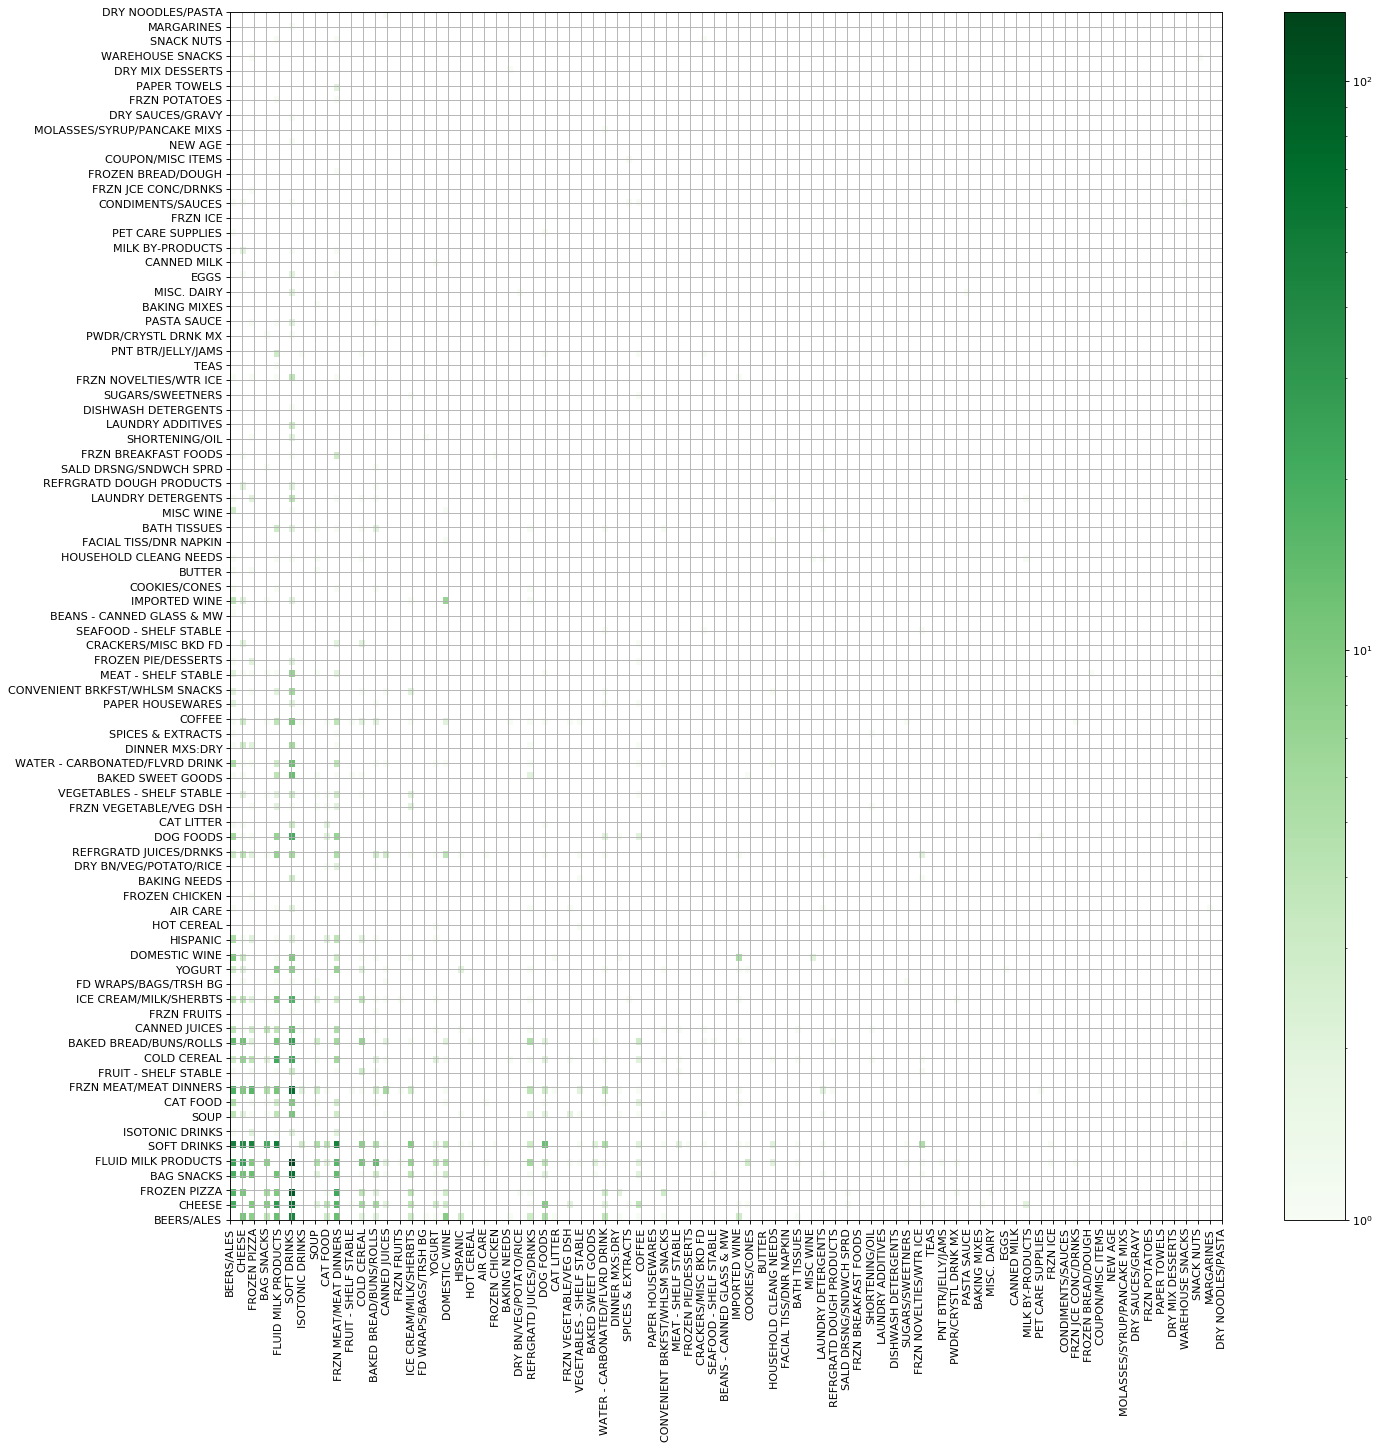

In [140]:
from matplotlib.colors import LogNorm
#fig, ax = plt.subplots(1,1)
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
#ax.hist2d(top_purchased_foods.COMMODITY_DESC1, top_purchased_foods.COMMODITY_DESC2, bins=100, cmap=plt.cm.BuGn_r)
# Set ticks labels for x-axis
plt.xticks(range(np.size(unique_com_desc)),num_to_desc.values(), rotation=90)
plt.yticks(range(np.size(unique_com_desc)),num_to_desc.values())
ax = plt.gca()
counts, xedges, yedges, im = ax.hist2d(top_purchased_foods.COMMODITY_DESC1, top_purchased_foods.COMMODITY_DESC2, bins=200,cmap='Greens',norm=LogNorm())
plt.colorbar(im, ax=ax)
plt.grid(True)

We can try to compare the mass of the products added most of the products are measured in ounces, pounds or mL

In [ ]:
def get_solid_weight(grocery_prod_df):
    "get size in oz"
    size_input = grocery_prod_df['CURR_SIZE_OF_PRODUCT']
    # check for OZ
    rex = re.search('[.0-9]{1,5}\s{0,1}OZ', size_input)
    if (rex!=None):
        rex = re.search('[.0-9]{1,5}',rex.group())
        size = float(rex.group())
    else:
        rex = re.search('[.0-9]{1,5}\s{0,1}LB',size_input)
        
        if rex != None:
            rex = re.search('[.0-9]{1,5}',rex.group())
            size = float(rex.group())*16
        else:
            size = np.nan
    return size
        
    
    
    

In [ ]:
product_df.set_index('PRODUCT_ID',inplace=True)

In [ ]:

product_weight = product_df[product_df['DEPARTMENT']=='GROCERY'].apply(get_solid_weight,axis=1).sort_values(ascending=False).rename('weight_in_oz')

In [ ]:
grocery_solid_prods = product_df.join(product_weight).dropna(subset=['weight_in_oz'],how='any')

In [ ]:
grocery_solid_prods

In [ ]:
transaction_product_id_df = transaction_data_df[['household_key','PRODUCT_ID','QUANTITY','SALES_VALUE','DAY']]\
.merge(grocery_solid_prods[['COMMODITY_DESC','SUB_COMMODITY_DESC','weight_in_oz']],\
       how='right',left_on='PRODUCT_ID',right_index=True)

In [ ]:
transaction_product_id_df

In [ ]:
transaction_product_id_df['tot_weight']=(transaction_product_id_df['weight_in_oz']*transaction_product_id_df['QUANTITY'])

In [ ]:
transaction_product_id_df.head()

In [ ]:
transaction_product_id_df[['sales_sum','weight_sum']]=transaction_product_id_df\
.groupby(['household_key','SUB_COMMODITY_DESC'])['SALES_VALUE','tot_weight']\
.transform('sum')
transaction_product_id_df.head()

In [ ]:
transaction_product_id_df.sort_values('weight_sum',ascending=False).groupby('household_key').head(1)\
.groupby('COMMODITY_DESC')['PRODUCT_ID'].count()\
.sort_values(ascending=False)\
.head(15).plot.bar(rot=90,figsize=(9,5))
ax = plt.gca()
ax.set_title('')